# SISTER CWL submission
***

In [65]:
import json
import os
import xml.etree.ElementTree as ET
import pandas as pd
import requests
import IPython
from itertools import groupby
import datetime as dt 
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

In [66]:
def get_quicklook(job_id):
    result = maap.getJobResult(job_id)
    granule = result.outputs[0]
    return f'{granule}/{os.path.basename(granule)}.png'

### Load production list with scene URLs


In [67]:
scene_df = pd.read_csv('./sister_production_2_list.csv', encoding='utf-8-sig')
# Strip unicode character
scene_df.l1_granule = scene_df.l1_granule.map(lambda x: x.replace('\ufeff',''))
scene_df.tail()

,Instrument,Type,Area,Flight Line,Platform,l1_granule,Valid URL,Priority,Notes
117,PRISMA,Aquatic,Boussole,20200727104033_20200727104037_0001,3,https://sister-ops-workspace.s3.us-west-2.amaz...,True,NONE,"Unknown ISOFIT error, datasets deleted from S3"
118,PRISMA,Validation,MOBY,20200224211336_20200224211340_0001,3,https://sister-ops-workspace.s3.us-west-2.amaz...,True,MEDIUM,VAL DATA MARKED QUESTIONABLE
119,PRISMA,Validation,La Crau RadCalNet,20200802104355_20200802104359_0001,3,https://sister-ops-workspace.s3.us-west-2.amaz...,True,LOW,PRIORITY CHANGED FROM HIGH TO LOW DUE TO MISSI...
120,PRISMA,Validation,Railroad Valley RadCalNet,20200911184039_20200911184043_0001,3,https://sister-ops-workspace.s3.us-west-2.amaz...,True,HIGH,NaN
121,PRISMA,Validation,Gobabeb RadCalNet,20200917091806_20200917091810_0001,3,https://sister-ops-workspace.s3.us-west-2.amaz...,True,HIGH,NaN


### Workflow configuration generator

The configuration generator function takes as input the URL to the L1 granule and a composite release identifier (crid) and returns a scene identifier along with a workflow configuration for the scene.

In [ ]:
def gen_config(l1_granule,crid):
    
    '''Generate CWL workflow configuration
    
    Arguments
    
    l1_granule (str): Input scene URL 
    
    Returns:
    
    identifier(str): Unique scene identification code
    
            SISTER_SENSOR_YYYMMDDTHHMMSS
        ex:
    
            SISTER_PRISMA_20200918T100312
            
    input_config (list): List of workflow PGE configurations

    '''
    landsat = 'None'   
    preprocess_queue = "sister-job_worker-16gb"
    segmentation_size = 50
    
    base_name = os.path.basename(l1_granule)
    
    if base_name.startswith('DESIS'):
        sensor = 'DESIS'
        datetime = base_name[31:46]
        
    elif base_name.startswith('PRS'):
        sensor = 'PRISMA'
        datetime = base_name[16:24] + 'T' + base_name[24:30]
        landsat='https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/landsat_reference/PRS_%s_landsat.tar.gz' % base_name[16:50]
        
    elif base_name.startswith('ang'):
        sensor = 'AVNG'
        datetime = base_name[3:18].upper()
        
    elif base_name.startswith('f'):
        sensor = 'AVCL'
        ''' AVIRIS classic filenames do not contain acquisition times,to be consistent with other
            sensors and to ensure identifier codes are unique a time string is created using other
            numbers in the filename            
        '''     
                
        datetime = "20%sT%s%s%s" % (base_name[1:7],
                                    base_name[8:10],
                                    base_name[11:13],
                                    base_name[14:16])
        
        preprocess_queue = "sister-job_worker-32gb"
        
        #Run large Sierra scenes with larger segmentation size
        if ('f130612' in base_name) or ('f210326' in base_name):
            segmentation_size = 100

    #Check if input file exists
    inputs_exist = requests.head(l1_granule).status_code != 500
    # Check if landsat reference file exists
    if sensor == 'PRISMA':
        inputs_exist &= requests.head(landsat).status_code != 500
        
    if not inputs_exist:
        print('Input file not found.')
        return False,False
        
    input_config =  [
    {
      "step_key": "l1_preprocess",
      "algorithm_id": "sister-preprocess",
      "version": "2.0.0",
      "queue": preprocess_queue,
      "params": {
        "raw_dataset": l1_granule,
        "landsat_dataset": landsat,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L1B_RDN_{datetime}_{crid}",
        "username":"anonymous"
      }
    },
    {
      "step_key": "l2_reflectance",
      "algorithm_id": "sister-isofit",
      "queue": "sister-job_worker-32gb",
      "version":"2.0.0",
      "input_filter": {
        "radiance_dataset":  f"*RDN*{crid}",
        "location_dataset": "*RDN*LOC",
        "observation_dataset": "*RDN*OBS",          
      },
      "params": {
        "radiance_dataset": None,
        "location_dataset": None,
        "observation_dataset": None,
        "n_cores": 32,
        "segmentation_size": segmentation_size,
        "crid": crid,
        "identifier": f"SISTER_{sensor}_L2A_RFL_{datetime}_{crid}",
        "username":"anonymous"
      },

    },
    {
      "step_key": "l2_resample",
      "algorithm_id": "sister-resample",
      "version":"2.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": f"*_RFL_*{crid}",
        "uncertainty_dataset": "*_RFL*UNC"

      },
      "params": {
        "reflectance_dataset": None,
        "uncertainty_dataset":None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2A_RSRFL_{datetime}_{crid}",
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2_reflectance_correction",
      "algorithm_id": "sister-reflect_correct",
      "version":"2.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "observation_dataset": "*RDN*OBS",
        "reflectance_dataset": f"*RSRFL*{crid}"
      },
      "params": {
        "observation_dataset": None,
        "reflectance_dataset": None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2A_CORFL_{datetime}_{crid}",
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2_frcover",
      "algorithm_id": "sister-fractional-cover",
      "version": "1.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*"
      },
      "params": {
        "reflectance_dataset": None,
        "n_cores": 10,
        "refl_scale": 1,
        "normalization": 'brightness',
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_FRCOVER_{datetime}_{crid}",
        "username":"anonymous"
      }
    },
    {
        "step_key": "l2b_router",
        "algorithm_id": "sister-algorithm_router",
        "version": "1.0.0",
        "queue": "sister-job_worker-16gb",
        "input_filter": {
          "frcov_dataset": "*L2B_FRCOV*",
          "reflectance_dataset": "*CORFL*"
        },
        "params": {
          "frcov_dataset": None,
          "reflectance_dataset": None,
          "snow_cover": 0.9,
          "veg_cover": 0.5,
          "min_pixels": 100,
          "crid": crid,
          "identifier": f"SISTER_{sensor}_L2B_ROUTER_{datetime}_{crid}",
          "routed_pge_identifier": f"SISTER_{sensor}_L2B_ROUTER_{datetime}_{crid}",
          "username": "anonymous",
          "maap_api_host" : "sister-api-int.imgspec.org"
        }
      }     
  ]

    return sensor,datetime,json.dumps(input_config,indent=4)
    

### Generate single CWL workflow configuration

In [ ]:
crid = 999
sensor,datetime,input_config = gen_config('https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/raw/PRS_L1_STD_OFFL_20201225185042_20201225185046_0001.zip',
                                    crid)
print(input_config)
print(sensor,datetime)

### Submit single CWL workflow job

In [ ]:
identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"

job_response = maap.submitJob(
       algo_id="run_sister_workflow",
       version="2.0",
       queue="sister-job_worker-8gb",
       identifier= identifier,
       username="anonymous",
       workflow_config=input_config)

print("Submitted %s CWL worflow job" %  identifier)
print("    Submission status: %s" % job_response.status )
print("    Submission status: %s" % job_response.id )


### Create list of granules to run and set CRID

In [ ]:
crid = "001"
granules = scene_df[scene_df.Priority == 'HIGH'].l1_granule
print(f"{len(granules)} files in granule list")

### Loop through dataframe and start a CWL workflow for each each input scene 

In [ ]:
for l1_granule in granules[:0]:
    scene_name = os.path.basename(l1_granule)       
    sensor,datetime,input_config = gen_config(l1_granule,crid)
    identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"
    print(f"Submitting {identifier}")
    print(l1_granule)
    
    if identifier:
        job = maap.submitJob(
            algo_id="run_sister_workflow",
            version="2.0",
            queue="sister-job_worker-8gb",
            identifier=identifier,
            username="anonymous",
            workflow_config=input_config)
        print(f"\tSubmission status: {job.status}")

# Monitor jobs
***

### Get list of jobs

_Rerun to retreive up-to-date job list_

In [134]:
job_list = maap.listJobs('anonymous').text
jobs  = json.loads(job_list)

### Set regex pattern to match tags

In [135]:
crid= "001"
pattern = f"^SISTER.*{crid}$"

### Cycle through jobs and store job information for tags matching regex pattern

In [136]:
production = {}
crid= "001"

for job in jobs['jobs']:
    job_id = list(job.keys())[0]
    tag = job[job_id]['tags'][0]
    tag = tag.upper()

    if re.match(pattern,tag):

        job_info = {}
        job_info['id'] = job_id
        job_info['status'] = job[job_id]['status'].replace('job-','')
        
        if 'CWL' in tag:
            sister,sensor,product,datetime,crid = tag.split('_')
            job_info['PGE'] = product
        else:
            sister,sensor,level,product,datetime,crid = tag.split('_')
            job_info['PGE'] = f'{level}_{product}'

        job_info['sensor'] = sensor

        if 'time_start' in job[job_id]['job']['job_info'].keys():
            start_time = job[job_id]['job']['job_info']['time_start']
        else:
            start_time = '2000-01-01T00:00:00.0Z'
        job_info['start_time'] =dt.datetime.strptime(start_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'time_end' in job[job_id]['job']['job_info'].keys():
            end_time = job[job_id]['job']['job_info']['time_end']
        else:
            end_time = '2000-01-01T00:00:00.0Z'
        job_info['end_time'] =dt.datetime.strptime(end_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'duration' in job[job_id]['job']['job_info'].keys():
            job_duration = float(job[job_id]['job']['job_info']['duration'])/60
        else:
            job_duration = -1

        job_info['duration'] =job_duration

        if 'facts' in job[job_id]['job']['job_info'].keys():
            if 'ec2_instance_type' in job[job_id]['job']['job_info']['facts'].keys():
                instance_type = job[job_id]['job']['job_info']['facts']['ec2_instance_type']
            else:
                instance_type = np.nan
        else:
            instance_type = np.nan

        job_info['instance_type'] = instance_type

        output_datasets = []
        input_datasets = []
        inputs_disk_usage = 0
        staged_disk_usage = 0

        if job_info['status'] == 'completed':
            if 'metrics' in job[job_id]['job']['job_info'].keys():
                for staged in job[job_id]['job']['job_info']['metrics']['products_staged']:
                    if staged['dataset_type'].startswith('L'):
                        staged_disk_usage+=staged['disk_usage']/1E9
                        for url in staged['urls']:
                            if url.startswith('http'):
                                output_datasets.append(url)

            for input_dataset in job[job_id]['job']['job_info']['metrics']['inputs_localized']:
                inputs_disk_usage += input_dataset['disk_usage']/1E9
                input_datasets.append(input_dataset['url'])

        job_info['output_datasets'] = output_datasets
        job_info['input_datasets'] = input_datasets
        job_info['inputs_disk_usage'] = inputs_disk_usage
        job_info['staged_disk_usage'] = staged_disk_usage
        
        if (tag not in production.keys()) | (job_info['status'] == 'completed'):
            production[tag] = job_info
        elif job_info['start_time'] > production[tag]['start_time']:
            production[tag] = job_info



### Group tags by tag datetimes and print statuses

In [137]:
tags = sorted( list(production.keys()), key=lambda x: x.split("_")[-2])

#Print only workflows with failed jobs
failed_only = False

for datetime, group in groupby(tags, lambda x: x.split("_")[-2]):
    group = [x for x in group]
        
    key ='_'.join(group[0].split('_')[:2])
    datetime = group[0].split('_')[-2]
    
    if failed_only:
        failed = 'failed' in [production[tag]['status'] for tag in group]
    else:
        failed = True
    
    if failed:
        print(f"{key}_*_{datetime}")

        for tag in group:
            status = production[tag]['status']
            if status == 'failed':
                status = f"\x1b[31m{status}\x1b[0m"
            elif status == 'completed':
                status = f"\x1b[34m{status}\x1b[0m"
            elif status == 'started':
                status = f"\x1b[32m{status}\x1b[0m"
            elif status == 'queued':
                status = f"\x1b[33m{status}\x1b[0m"

            print(f"\t {tag}")
            print(f"\t\t Job status: {status}")
            print(f"\t\t Job ID: {production[tag]['id']}")


SISTER_AVCL_*_20060426T010003
	 SISTER_AVCL_L1B_RDN_20060426T010003_001
		 Job status: completed
		 Job ID: 465fbcf1-04f7-4f20-834e-372cfd4cefb6
	 SISTER_AVCL_L2A_RFL_20060426T010003_001
		 Job status: failed
		 Job ID: f9e84f1a-ed26-4afb-a238-7881a89fb0ad
	 SISTER_AVCL_CWL_20060426T010003_001
		 Job status: failed
		 Job ID: 460557f8-6462-490b-bcc2-ed473a45ea90
SISTER_AVCL_*_20110513T010003
	 SISTER_AVCL_L1B_RDN_20110513T010003_001
		 Job status: completed
		 Job ID: efcf45a6-4730-4194-8f6d-c6fba49e2da0
	 SISTER_AVCL_L2B_FRCOVER_20110513T010003_001
		 Job status: completed
		 Job ID: beb3feec-41e6-4737-86cc-ea238a91554c
	 SISTER_AVCL_L2B_ROUTER_20110513T010003_001
		 Job status: completed
		 Job ID: fb2d37a3-092b-4c7b-a1ee-5a359fd5138b
	 SISTER_AVCL_L2A_RSRFL_20110513T010003_001
		 Job status: completed
		 Job ID: 207ca7f6-ecc5-4bce-b4e3-15d00b08af84
	 SISTER_AVCL_L2B_VEGBIOCHEM_20110513T010003_001
		 Job status: completed
		 Job ID: b47bca87-54f4-4b64-af30-cddcf67eb845
	 SISTER_AVCL_

### Print full individual job info

In [138]:
job_info = production['SISTER_AVCL_L2B_VEGBIOCHEM_20130612T010014_001']
job_info

{'id': '9597b5fa-7f50-4c02-816b-a6d252371152',
 'status': 'completed',
 'PGE': 'L2B_VEGBIOCHEM',
 'sensor': 'AVCL',
 'start_time': datetime.datetime(2023, 2, 17, 23, 30, 26, 649358),
 'end_time': datetime.datetime(2023, 2, 17, 23, 30, 52, 87613),
 'duration': 0.4239709166666667,
 'instance_type': 'c5.9xlarge',
 'output_datasets': ['http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVCL/L2B_VEGBIOCHEM/2013/06/12/SISTER_AVCL_L2B_VEGBIOCHEM_20130612T191820_001',
  'http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVCL/L2B_VEGBIOCHEM/2013/06/12/SISTER_AVCL_L2B_VEGBIOCHEM_20130612T191820_001_CHL',
  'http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVCL/L2B_VEGBIOCHEM/2013/06/12/SISTER_AVCL_L2B_VEGBIOCHEM_20130612T191820_001_LMA',
  'http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVCL/L2B_VEGBIOCHEM/2013/06/12/SISTER_AVCL_L2B_VEGBIOCHEM_20130612T191820_001_NIT'],
 'input_datasets': [

# Display quicklook

### Use job ID to retrieve quicklook url and display

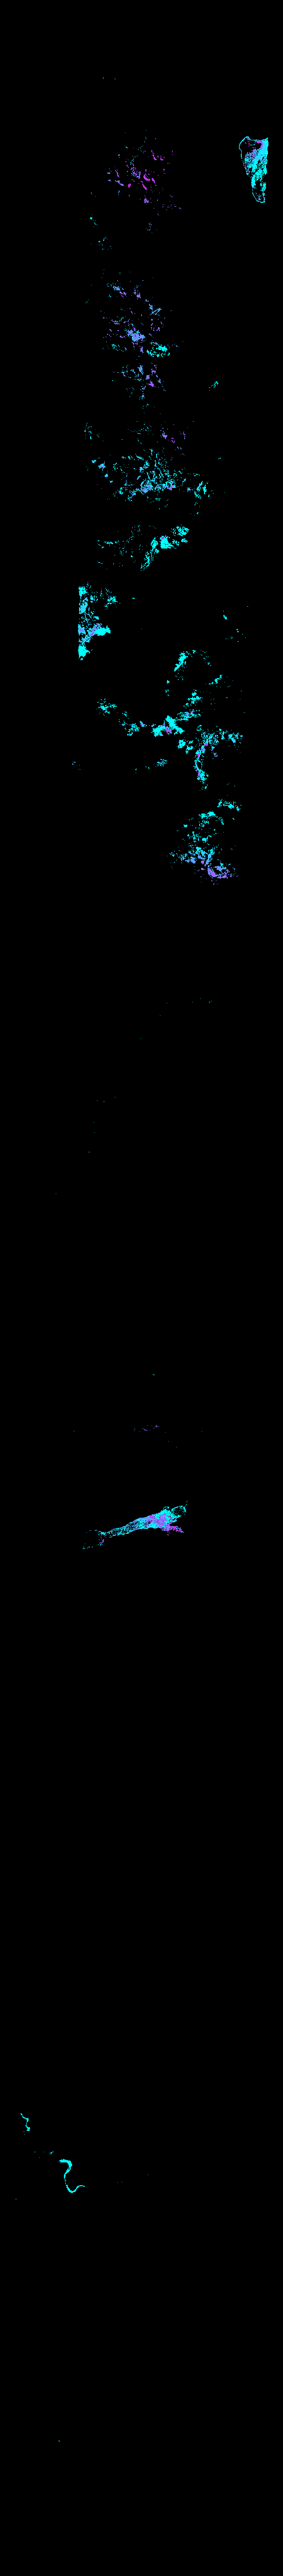

In [129]:
png = get_quicklook('f6093543-da14-41a7-b4f5-7bd8c5238176')
IPython.display.Image(png)

# Rerun resample and correction PGEs

In [139]:
production_df = pd.DataFrame(index = production.keys(),
                        columns = job_info.keys())

for tag in production.keys():
    production_df.loc[tag,:] = [production[tag][key] for key in job_info.keys()]
    
production_complete = production_df[production_df.status == 'completed']
production_complete.head()

,id,status,PGE,sensor,start_time,end_time,duration,instance_type,output_datasets,input_datasets,inputs_disk_usage,staged_disk_usage
SISTER_AVNG_L2A_RFL_20220405T185108_001,459ec647-8cd1-4fff-956c-8e69ee88da24,completed,L2A_RFL,AVNG,2023-02-14 21:48:17.551557,2023-02-14 22:00:10.560420,11.883481,c5.9xlarge,[http://sister-ops-workspace.s3-website.us-wes...,[s3://s3.us-west-2.amazonaws.com:80/sister-ops...,0.160684,0.303605
SISTER_AVNG_L1B_RDN_20220412T215642_001,44c86048-721c-4bed-9447-a17a6626cf99,completed,L1B_RDN,AVNG,2023-02-14 21:47:39.048528,2023-02-14 21:51:42.677808,4.060488,t3a.xlarge,[http://sister-ops-workspace.s3-website.us-wes...,[https://popo.jpl.nasa.gov/avng/y22/ang2022041...,4.740004,0.145317
SISTER_AVNG_L2A_RFL_20220420T212903_001,a0d400f2-7d59-4a4d-ac66-8273db4f5aab,completed,L2A_RFL,AVNG,2023-02-14 22:13:57.832588,2023-02-14 22:19:31.587094,5.562575,c5.9xlarge,[http://sister-ops-workspace.s3-website.us-wes...,[s3://s3.us-west-2.amazonaws.com:80/sister-ops...,0.04856,0.091896
SISTER_AVNG_L2A_RSRFL_20220405T185108_001,5ad67952-527a-4973-ba02-01a62e7e7720,completed,L2A_RSRFL,AVNG,2023-02-14 22:01:13.821107,2023-02-14 22:01:54.434660,0.676893,t3a.xlarge,[http://sister-ops-workspace.s3-website.us-wes...,[s3://s3.us-west-2.amazonaws.com:80/sister-ops...,0.303605,0.15069
SISTER_AVNG_CWL_20220405T185108_001,9c58ff96-30b3-4698-b035-a7ae314b2adf,completed,CWL,AVNG,2023-02-14 21:33:44.379989,2023-02-14 22:11:09.681477,37.421691,t3a.large,[],[],0,0


In [141]:
crid = "001"
count = 0
#.iloc[[0,118,50,90]]

for r,row in scene_df.iterrows():
    base_name = os.path.basename(row.l1_granule)
    if base_name.startswith('DESIS'):
        sensor = 'DESIS'
        datetime = base_name[31:46]
    elif base_name.startswith('PRS'):
        sensor = 'PRISMA'
        datetime = base_name[16:24] + 'T' + base_name[24:30]        
    elif base_name.startswith('ang'):
        sensor = 'AVNG'
        datetime = base_name[3:18].upper()
    elif base_name.startswith('f'):
        sensor = 'AVCL'              
        datetime = "20%sT%s%s%s" % (base_name[1:7],
                                    base_name[8:10],
                                    base_name[11:13],
                                    base_name[14:16])

    rfl_identifier = f"SISTER_{sensor}_L2A_RFL_{datetime}_{crid}"
    
    if rfl_identifier in production_complete.index:
        
        urls = production_df.loc[rfl_identifier]['output_datasets']
        urls.sort()
        l2a_rfl,l2a_unc = urls
        l2a_rfl = l2a_rfl.replace('http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/',
                                  's3://s3.us-west-2.amazonaws.com:80/sister-ops-workspace/')
        l2a_unc= l2a_unc.replace('http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/',
                                 's3://s3.us-west-2.amazonaws.com:80/sister-ops-workspace/')
        
        count+=1
        status = "unsubmitted"
        attempt= 0
        
        rsrfl_identifier = f"SISTER_{sensor}_L2A_RSRFL_{datetime}_{crid}"

        print(f'Identifier: {rsrfl_identifier}')
        
#         while status != 'success':
#             attempt+=1
#             start_time = dt.datetime.now()
#             resample_job_response = maap.submitJob(
#                                             algo_id="sister-resample",
#                                             version="2.0.1",
#                                             reflectance_dataset= l2a_rfl,
#                                             uncertainty_dataset= l2a_unc,
#                                             crid = "001",
#                                             publish_to_cmr=False,
#                                             cmr_metadata={},
#                                             queue="sister-job_worker-16gb",
#                                             identifier=rsrfl_identifier)
#             status = resample_job_response.status
#             duration = (dt.datetime.now()-start_time).seconds
#             print(f'\tSubmission retry {attempt} status: {status}')
#             print(f'\t\tJob ID: {resample_job_response.id}')
#             print(f'\t\t\tDuration {duration} seconds')


Identifier: SISTER_AVCL_L2A_RSRFL_20170127T010026_001
Identifier: SISTER_PRISMA_L2A_RSRFL_20200224T211336_001
Identifier: SISTER_AVNG_L2A_RSRFL_20220503T210356_001
Identifier: SISTER_DESIS_L2A_RSRFL_20220606T114600_001


In [142]:
print(count)

4


In [123]:
rfl_identifier

'SISTER_AVCL_L2A_RFL_20170127T010026_001'